In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [75]:
#Open data
data_file = open('Test.txt').read()
data_file

#Create tokenizer object
tokenizer = Tokenizer(char_level = False)

data = data_file.lower().splitlines()

data = list(filter(lambda x: x != '##', data))

new_data = data

for paragraph in range(len(data)):
    sentences = data[paragraph].split('.')
    if sentences != ' ':
        new_data[paragraph] = sentences
    
data = new_data

In [76]:
###Add start stop tokens###
start_token = '<start>'
end_token = ' <end>'
new_data = data
max_sentence_length = 0

for paragraph in range(len(data)):
    para = data[paragraph]

    for sentence in range(len(para)):
        para[sentence] = start_token + para[sentence]
        para[sentence] = para[sentence] + end_token

        num_words =  len(para[sentence].split())
        if max_sentence_length < num_words:
            max_sentence_length = num_words

    new_data[paragraph] = para
      

data = new_data
data[0]

['<start>the important thing is not to stop questioning <end>',
 '<start> curiosity has its own reason for existence <end>',
 '<start> one cannot help but be in awe when he contemplates the mysteries of eternity, of life, of the marvelous structure of reality <end>',
 '<start> it is enough if one tries merely to comprehend a little of this mystery each day <end>',
 '<start> <end>']

In [77]:
start_end = token = np.zeros(max_sentence_length, dtype=int)
start_end[0] = 1
start_end[1] = 2
start_end

array([1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [78]:
def Encode_Inputs(data, max_sentence_length):
    input_sequences = list()
    output_sequences = list()
    new_input = list()
    new_output = list()
    
    for paragraph in range(len(data)):
        para = data[paragraph]

        tokenized_sentence = para
        tokenizer.fit_on_texts(tokenized_sentence)

        #Transforms sentences into set of integers from the dictionary
        tokenized_sentence = tokenizer.texts_to_sequences(tokenized_sentence)

        #Pad sequences to length of max_length
        tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen = max_sentence_length, padding ='post', value = 0)
        total_words = len(tokenizer.word_index) + 1    

        roll_amount = tokenized_sentence.shape[1] * (tokenized_sentence.shape[0]-1)
        output_tokens = np.array(np.roll(tokenized_sentence, roll_amount))
        output_tokens[-1] = 0

        input_sequences.append(tokenized_sentence)
        output_sequences.append(output_tokens)

    input_sequences = np.vstack(input_sequences)
    output_sequences = np.vstack(output_sequences)
    
    for seq in range(len(input_sequences)):
        if  not np.array_equal(input_sequences[seq], start_end):
            new_input.append(input_sequences[seq])
    
    for seq in range(len(output_sequences)):
        if  not np.array_equal(output_sequences[seq], start_end):
            new_output.append(output_sequences[seq])
            
    new_input = np.vstack(new_input)
    new_output = np.vstack(new_output)

    return new_input, new_output, total_words

In [79]:
def Decode_Inputs(input_sequences):
    no_start_end_tokens = list()
    temp = list()

    for row in range(len(input_sequences)):
        for col in range(len(input_sequences[1])):
            if  not input_sequences[row][col] == 1 and not input_sequences[row][col] == 2 :
                temp.append(input_sequences[row][col])
        no_start_end_tokens.append(temp)
        temp = list()


    data = np.vstack(no_start_end_tokens)    
    data = tokenizer.sequences_to_texts(data)
    return data

In [80]:
input_sequences, output_sequences, total_words = Encode_Inputs(data, max_sentence_length)
post_output_sequences = np.array(np.roll(output_sequences, max_sentence_length-1))
for row in range(len(post_output_sequences)):
    post_output_sequences[row][max_sentence_length-1] = 0
    
print('Total Words: ', total_words)
print('Input Sequences Shape: ', input_sequences.shape)
print('Output Sequences Shape: ', output_sequences.shape)

Total Words:  170
Input Sequences Shape:  (20, 24)
Output Sequences Shape:  (20, 24)


In [81]:
print('Input:', Decode_Inputs(input_sequences))
print('Target:', Decode_Inputs(output_sequences))

Input: ['to it when i with of for but', 'in a this like have here and', 'is one if letter me on see as it’s berlin to well the who the people the to will turn the out', 'important i thing not is stop questioning of curiosity has its the own reason existence cannot', 'he like contemplates have mysteries eternity', 'of life marvelous the structure reality the to enough i to tries merely it of comprehend the little', 'mystery to each of day the your made when very happy', 'this of would come a back matter the skimpy is when birdfeed i return the zurich at', 'it moment leave business trip to like of can arrange but i’ll go arosa is have couple', 'days tete adn in arrived yesterday', 'was they didn’t look of properly my train leaves 2 hours', 'one regards health incidentally am feeling infinitely better to than last the brilliant and when sunshine sweet chocolate if', 'grand the read about', 'like goings from is up monday schoolmastering', 'sparkling scenery and well fed citizens who have n

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 22 and the array at index 3 has size 24

In [15]:
class Transformer_Block(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer_Block, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [17]:
class MaskedTransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(MaskedTransformerBlock, self).__init__()
        self.att1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.att2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
        key_dim=embed_dim)
        self.ffn = keras.Sequential(
        [keras.layers.Dense(ff_dim, activation="gelu"),
        keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training):
        input_shape = tf.shape(inputs[0])
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        mask = self.causal_attention_mask(batch_size,
        seq_len, seq_len,
        tf.bool)
        attn_output1 = self.att1(inputs[0], inputs[0],
        attention_mask = mask)
        attn_output1 = self.dropout1(attn_output1, training=training)
        out1 = self.layernorm1(inputs[0] + attn_output1)
        attn_output2 = self.att2(out1, inputs[1])
        attn_output2 = self.dropout2(attn_output2, training=training)
        out2 = self.layernorm1(out1 + attn_output2)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm2(out2 + ffn_output)

In [18]:
class MaskedTokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(MaskedTokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen+1,
        output_dim=embed_dim,
        mask_zero=True)
 
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=1, limit=maxlen+1, delta=1)
        positions = positions * tf.cast(tf.sign(x),tf.int32)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def MaskedSparseCategoricalCrossentropy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
def MaskedSparseCategoricalAccuracy(real, pred):
    accuracies = tf.equal(tf.cast(real,tf.int64), tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [23]:
#Variables
embed_dim = 128
data = input_sequences
training = True
total_words = total_words
max_sentence_length = max_sentence_length
num_heads = 6
ff_dim = 16
dropout = 0.15

encoder_stack = 6
decoder_stack = 6

2022-04-30 19:08:35.504235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-30 19:08:35.504306: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-30 19:08:35.504384: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-klg6z): /proc/driver/nvidia/version does not exist
2022-04-30 19:08:35.504767: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


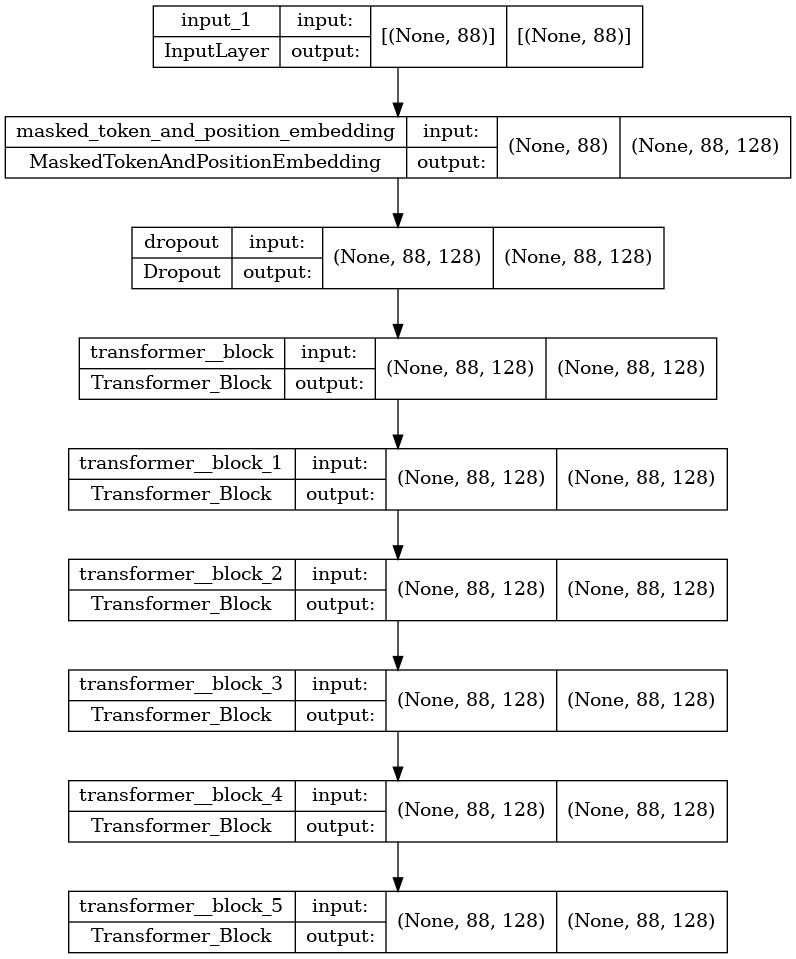

In [24]:
#Encoder

#Sequence input
input_layer = keras.layers.Input(shape=input_sequences.shape[1:])
encoder = MaskedTokenAndPositionEmbedding(input_sequences.shape[1], total_words, embed_dim)(input_layer)

#Dropout
dropout_layer = keras.layers.Dropout(dropout, noise_shape=encoder.shape[:-1]+(1,))(encoder)
encoder = dropout_layer

for i in range(encoder_stack):
      encoder = Transformer_Block(embed_dim, num_heads, ff_dim, dropout)(encoder)                                                                    

encoder_model = keras.Model(input_layer, encoder, name='Encoder')
keras.utils.plot_model(encoder_model,show_shapes=True,expand_nested=True)

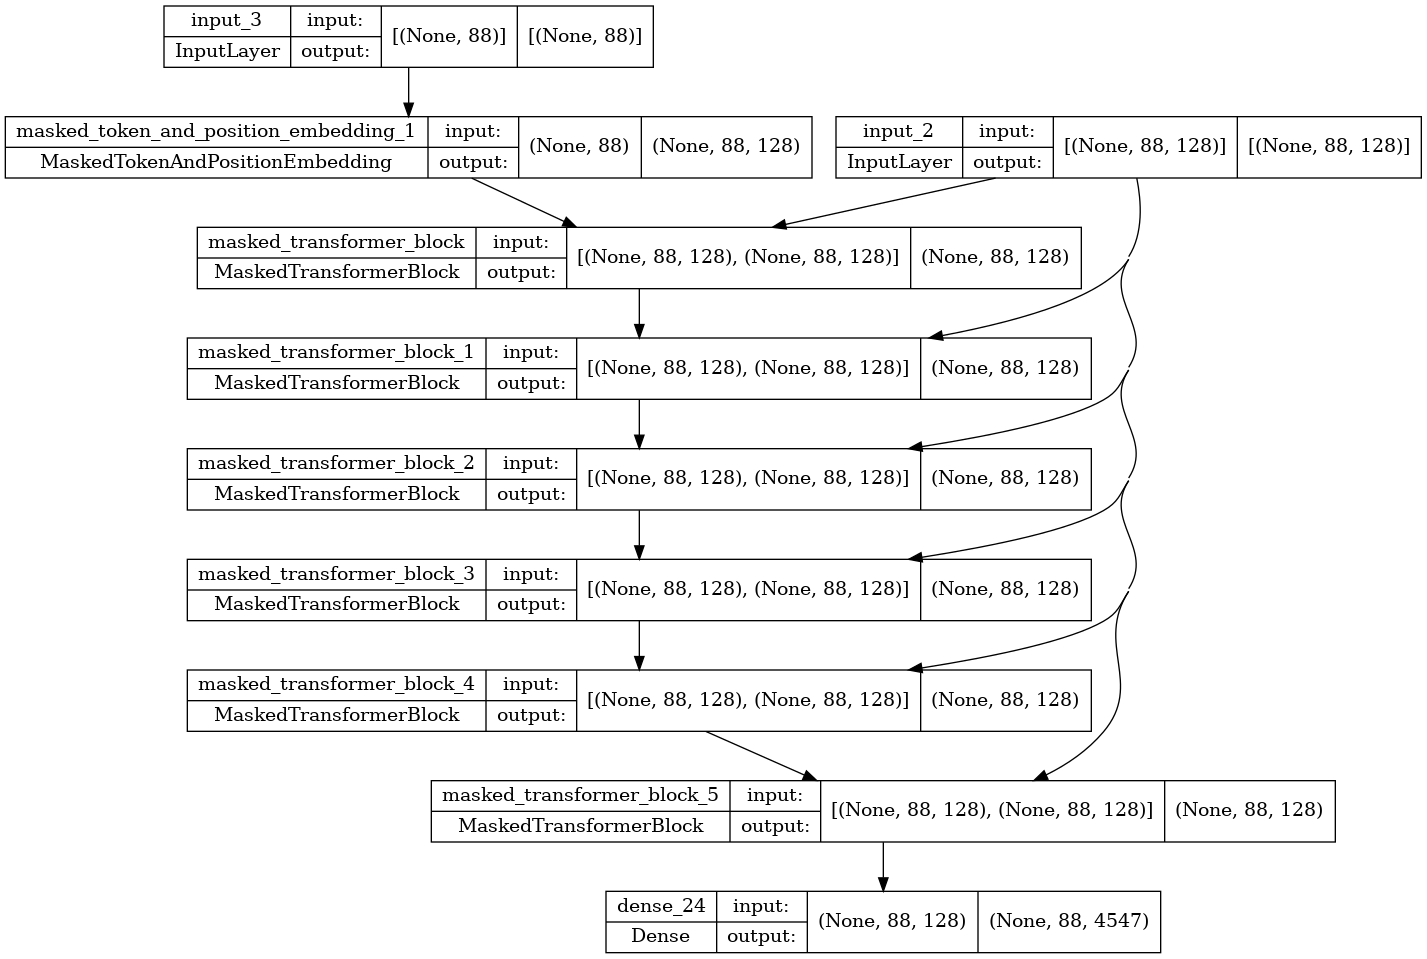

In [25]:
#Decoder 

#Encoder output (input)
encoder_input_layer = keras.layers.Input(shape = encoder_model.output_shape[1:])

#Decoder target input
input_layer = keras.layers.Input(shape = output_sequences.shape[1:])
position_embedding_layer = MaskedTokenAndPositionEmbedding(output_sequences.shape[1], total_words, embed_dim)(input_layer)
decoder = position_embedding_layer

for i in range(decoder_stack):
    decoder = MaskedTransformerBlock(embed_dim, num_heads, ff_dim, dropout)([decoder, encoder_input_layer])
    
linear_layer = keras.layers.Dense(total_words)(decoder)

decoder_model = keras.Model([input_layer, encoder_input_layer], linear_layer)
keras.utils.plot_model(decoder_model,show_shapes=True,expand_nested=True)

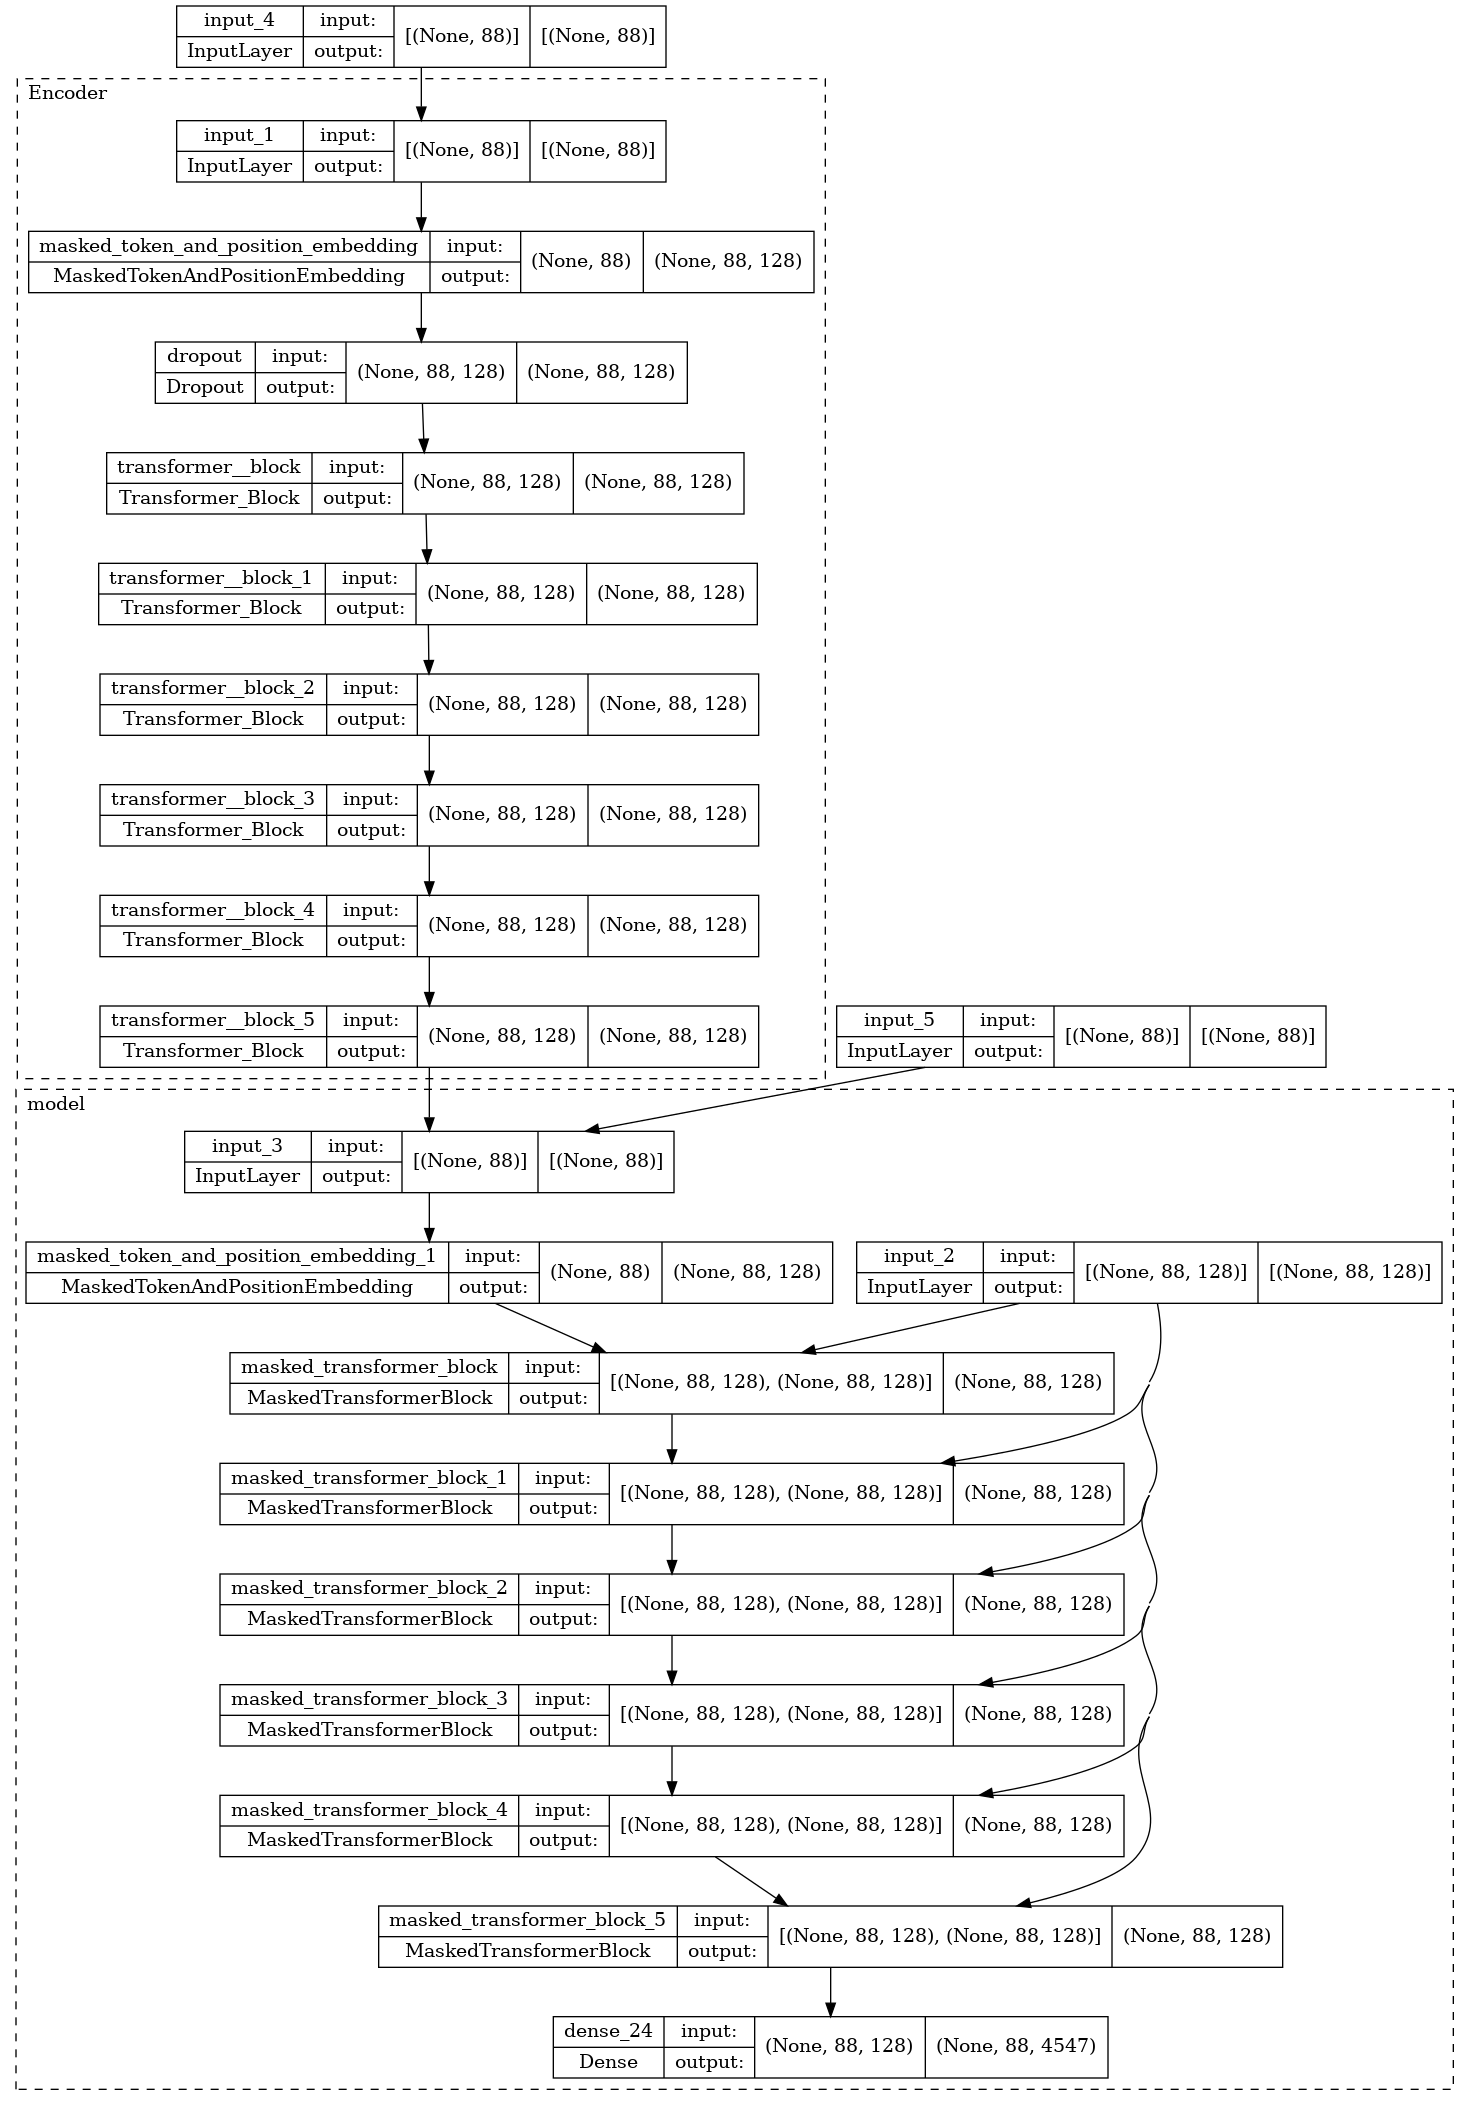

In [26]:
sequences = keras.layers.Input(encoder_model.input_shape[1:])
targets = keras.layers.Input(decoder_model.input_shape[0][1:])

transformer = decoder_model([targets, encoder_model(sequences)])
transformer = keras.Model([sequences, targets], transformer)

keras.utils.plot_model(transformer,show_shapes=True,expand_nested=True)

In [27]:
transformer.compile(loss=MaskedSparseCategoricalCrossentropy, optimizer=keras.optimizers.Adam(), metrics=[MaskedSparseCategoricalAccuracy])
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 88)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 88)]         0           []                               
                                                                                                  
 Encoder (Functional)           (None, 88, 128)      2995808     ['input_4[0][0]']                
                                                                                                  
 model (Functional)             (None, 88, 4547)     5956259     ['input_5[0][0]',                
                                                                  'Encoder[0][0]']          

In [28]:
batch_size = 10
epochs = 5

history = transformer.fit([input_sequences, output_sequences], post_output_sequences, batch_size=batch_size, epochs=epochs, validation_data=([input_sequences, output_sequences], post_output_sequences), verbose=1)

Epoch 1/5
133/191 [===================>..........] - ETA: 2:03 - loss: 6.2077 - MaskedSparseCategoricalAccuracy: 0.1303

KeyboardInterrupt: 

In [ ]:
print('Training Accuracy:',transformer.evaluate([input_sequences, output_sequences] ,post_output_sequences)[1]*100.0,'%')

17/60 [=======>......................] - ETA: 1:44 - loss: 0.0031 - MaskedSparseCategoricalAccuracy: 1.0000

In [ ]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['MaskedSparseCategoricalAccuracy'])
plt.plot(history.history['val_MaskedSparseCategoricalAccuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training'],loc='lower right')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training'],loc='upper right') 

In [ ]:
#Teacher Forcing
TF_Output_Predictions(number):    
    result = transformer.predict([input_sequences[number],output_sequences[number]])
    result.argmax(-1)[0]
    result = Decode_Inputs(result.argmax(-1))
    
    MaskedSparseCategoricalAccuracy(post_output_sequences[number],result).numpy()*100.0
    
    return result, accuracy, input_sequences[number], output_sequences[number]

In [ ]:
#Non Teacher Forcing
NTF_Output_Prediction(sentence):
    #Tokenize sentence
    tokenized_sentence = ['theory of relativity']
    tokenized_sentence[0] = start_token + tokenized_sentence[0]
    tokenized_sentence[0] = tokenized_sentence[0] + end_token
    tokenizer.fit_on_texts(tokenized_sentence)
    tokenized_sentence = tokenizer.texts_to_sequences(tokenized_sentence)
    tokenized_sentence = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sentence, maxlen = max_sentence_length, padding ='post', value = 0)
    
    #Pass into model
    context = encoder_model.predict(tokenized_sentence)
    token = np.zeros(tokenized_sentence.shape)
    token[:,0] = 1 
    result = decoder_model.predict([token,context]).argmax(-1)
    token[:,1] = result[:,1]
    result = decoder_model.predict([token,context])
    result = Decode_Inputs(result.argmax(-1))

    #MaskedSparseCategoricalAccuracy(result).numpy()*100.0
    
    return tokenized_sentence